In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import cv2
import numpy as np
import random
import math

from helpers import *
from unet_model import multi_unet_model, jacard_coef  
from skimage.io import imread, imshow
from tqdm import tqdm
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image, ImageOps

In [2]:
print(tf.__version__)
tf.random.set_seed(42) # To load models 
np.random.seed(42)
random.seed(42)

2.11.0


In [3]:
ROOT_DIRECTORY = 'training/'
PATCH_SIZE = 256
NUMBER_IMAGES_TRAINING = 100
TRAIN_PATH_IMAGES = 'training/images/'
TRAIN_PATH_GROUNDTRUTH = 'training/groundtruth/'
TEST_PATH = 'test_set_images/'

In [4]:
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
position = 0
for path, subdirs, files in os.walk(ROOT_DIRECTORY):
    dirname = path.split("/")[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in tqdm(enumerate(images), total=NUMBER_IMAGES_TRAINING):
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if image_name.endswith(".png"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image) 
                #Extract patches from each image
                #print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 
                        image_dataset.append(single_patch_img)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.49it/s]


In [5]:
mask_dataset = []  
position = 0
for path, subdirs, files in os.walk(ROOT_DIRECTORY):
    #print(path)  
    dirname = path.split("/")[-1]
    if dirname == 'groundtruth':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        for i, mask_name in tqdm(enumerate(masks), total=NUMBER_IMAGES_TRAINING):  
            if i+1 > NUMBER_IMAGES_TRAINING:
                break
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                #print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (PATCH_SIZE, PATCH_SIZE, 1), step=PATCH_SIZE)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.   
                        mask_dataset.append(single_patch_mask) 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.91it/s]


In [6]:
# Test images
test_ids = os.listdir(TEST_PATH)
test_dataset = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    image = Image.open(path+"/"+ id_+".png")
    new_size_X = math.ceil(image.size[1]/PATCH_SIZE)*PATCH_SIZE
    new_size_Y = math.ceil(image.size[0]/PATCH_SIZE)*PATCH_SIZE
    image = resize_with_padding(image, (new_size_X, new_size_Y))
    image = np.array(image)  #Read each image as BGR
    #print(image.shape)
    SIZE_X = (image.shape[1]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
    SIZE_Y = (image.shape[0]//PATCH_SIZE)*PATCH_SIZE #Nearest size divisible by our patch size
    image = Image.fromarray(image)
    image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
    #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
    image = np.array(image) 
    #Extract patches from each image
    #print("Now patchifying image:", path+"/"+image_name)
    patches_img = patchify(image, (PATCH_SIZE, PATCH_SIZE, 3), step=PATCH_SIZE)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]

            #Use minmaxscaler instead of just dividing by 255. 
            #single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

            #single_patch_img = (single_patch_img.astype('float32')) / 255. 
            single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds. 
            test_dataset.append(single_patch_img)

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 65.84it/s]

Done!


In [7]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset, dtype=np.bool_)
test_dataset = np.array(test_dataset)

In [8]:
print(image_dataset.shape)
print(mask_dataset.shape)
print(test_dataset.shape)

(2500, 256, 256, 3)
(2500, 256, 256, 1)
(450, 256, 256, 3)


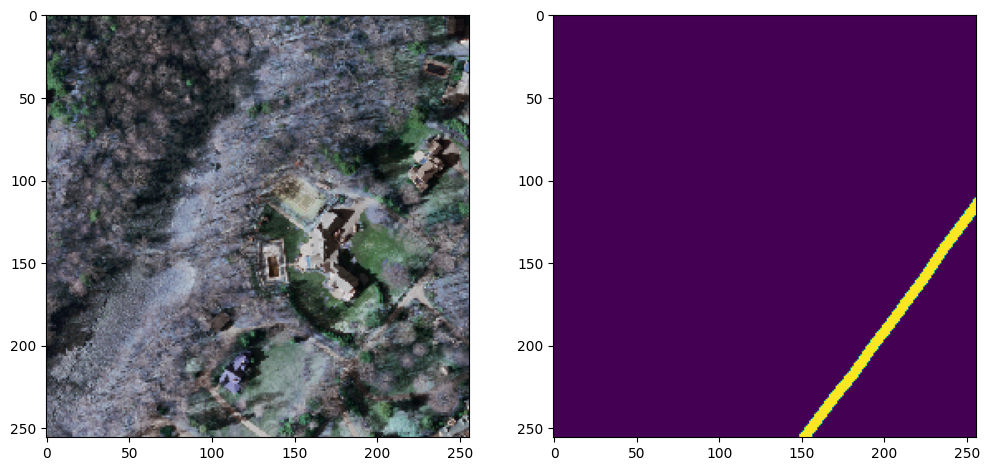

In [9]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (PATCH_SIZE, PATCH_SIZE, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (PATCH_SIZE, PATCH_SIZE, 1)))
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [11]:
print(X_train.shape)

(2000, 256, 256, 3)


In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
checkpoint_path = "check_points/unet_model_1"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)]

model.fit(X_train, y_train,
            batch_size = 16, 
            verbose=1, 
            epochs=6, 
            validation_data=(X_test, y_test), 
            shuffle=False,
            callbacks=callbacks)

model.save("models/unet_model_1.h5")

Epoch 1/6


In [12]:
custom_objects = {"jacard_coef": jacard_coef}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('models/unet_model_1.h5')

In [14]:
preds_train = model.predict(image_dataset[:int(image_dataset.shape[0]*0.9)], verbose=1)
preds_val = model.predict(image_dataset[int(image_dataset.shape[0]*0.9):], verbose=1)
preds_test = model.predict(test_dataset, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

15/15 [==============================] - 12s 823ms/step


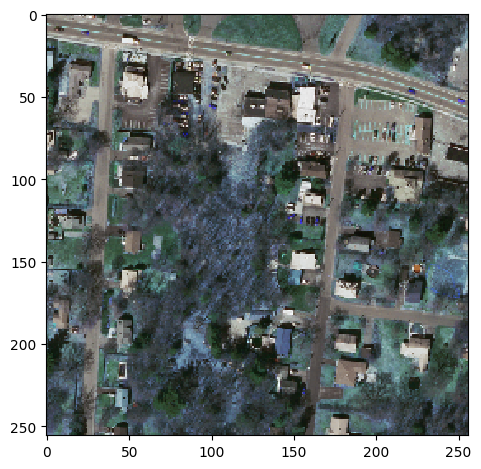

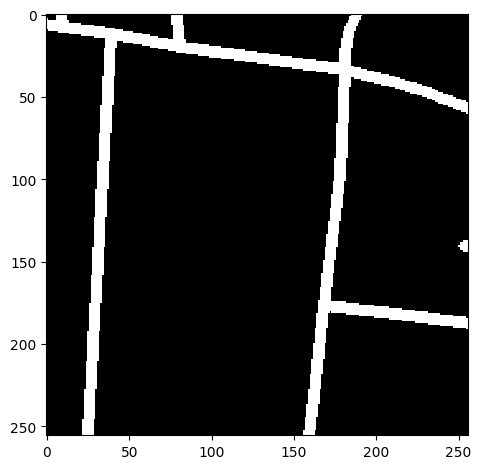

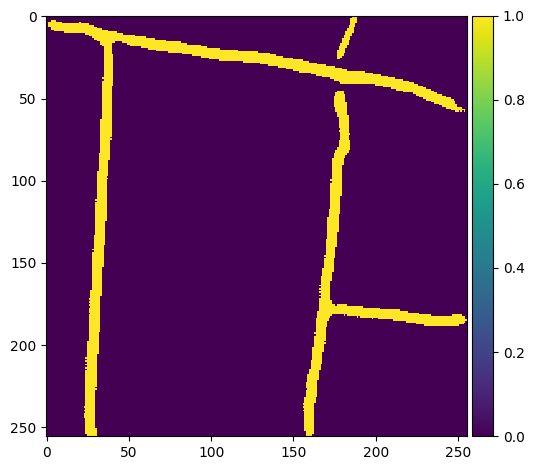

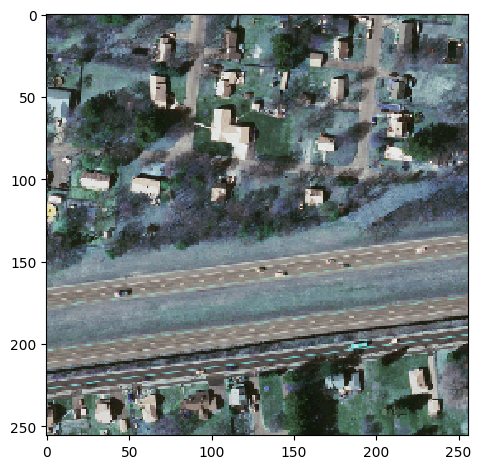

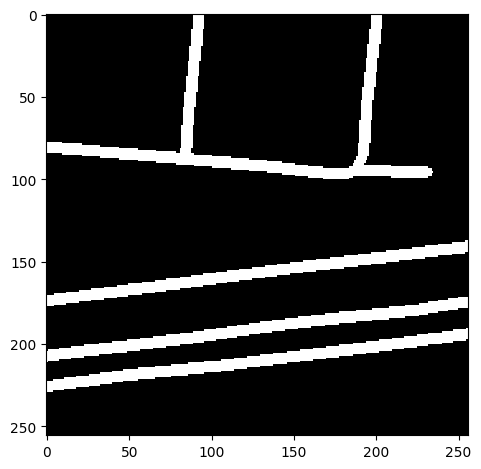

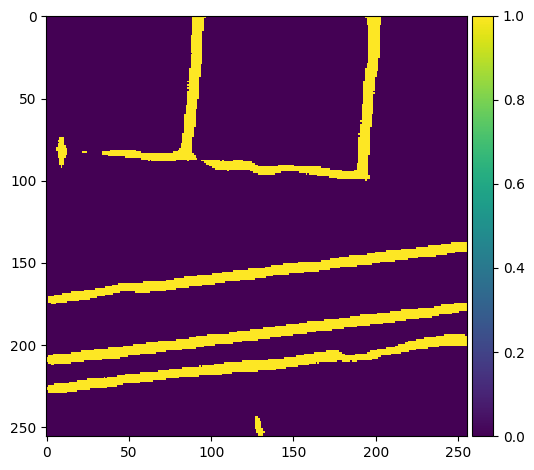

In [17]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(image_dataset[ix])
plt.show()
imshow(np.squeeze(mask_dataset[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(image_dataset[int(image_dataset.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(mask_dataset[int(mask_dataset.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

(450, 256, 256, 1)


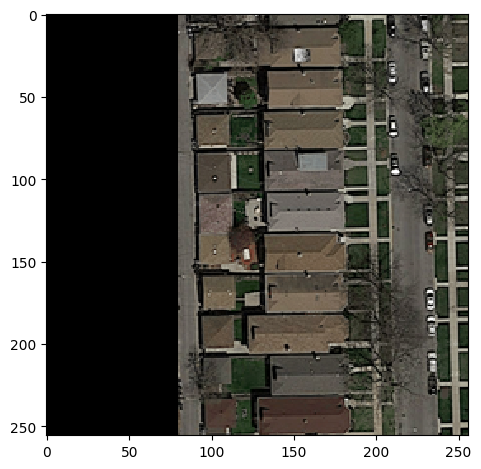

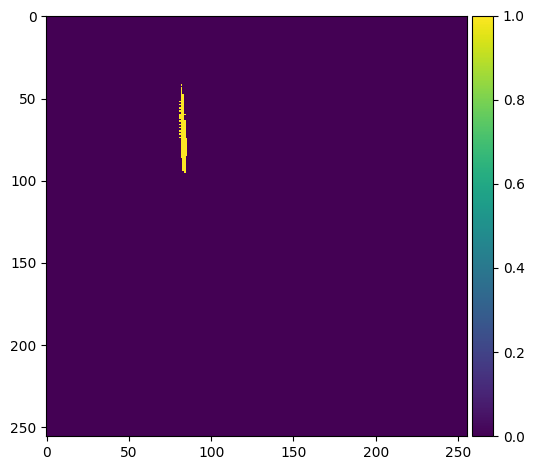

In [23]:
print(preds_test_t.shape)
ix = random.randint(0, len(preds_test_t))
imshow(test_dataset[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

In [25]:
submission = []
# The constants with _SIDE mean how many patches fit per image in one dimension (one side)
TEST_IMAGE_LENGTH = 608
PATCHES_PER_IMAGE_SIDE = math.ceil(TEST_IMAGE_LENGTH/PATCH_SIZE)
PATCHES_PER_IMAGE = PATCHES_PER_IMAGE_SIDE**2
SUBIMAGES_PER_PATCH_SIDE = PATCH_SIZE/16
for i, pred in enumerate(preds_test):
    img_id = test_ids[i//PATCHES_PER_IMAGE]
    # Format the image id
    id = img_id.split('_')[1].zfill(3)
    # Make sure the patch size is a multiple of 16 otherwise this line won't work
    preds = split_into_patches(pred, 16)
    for j, img in enumerate(preds):
        # Calculate the index of each subimage (in terms of pixels)
        x = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) % PATCHES_PER_IMAGE_SIDE) + j % SUBIMAGES_PER_PATCH_SIDE)
        y = 16*(SUBIMAGES_PER_PATCH_SIDE*((i % PATCHES_PER_IMAGE) // PATCHES_PER_IMAGE_SIDE) + j // SUBIMAGES_PER_PATCH_SIDE)
        # Don't add the padding predictions
        if x < TEST_IMAGE_LENGTH and y < TEST_IMAGE_LENGTH:
            # For now we calculate the average over all the pixels and check if it's above 0.5
            submission.append((f"{id}_{x:.0f}_{y:.0f}", 1 if img.mean() > 0.5 else 0))
np.savetxt("predictions.csv", np.asarray(submission), fmt="%s", delimiter=",", newline="\n", header="id,prediction", comments="")